# Computations notebook

We will calculate all constants and plot all graphs using python, this Jupyter notebook is a place where we will do it.

## Importing modules & reading file

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

RND_SEED = 42

In [2]:
data = pd.read_csv('data/case0202.csv')
data.head()

,Unaffect,Affected
0,1.94,1.27
1,1.44,1.63
2,1.56,1.47
3,1.58,1.39
4,2.06,1.93


In [3]:
una = data['Unaffect']
aff = data['Affected']

In [4]:
n = una.shape[0]
print(f"Number of samples: {n}")

Number of samples: 15


## Estimating mean, variance and median. Plotting histograms and ecdf

In [5]:
def estimate(X):
    print(f'{'Mean:' :<30}{X.mean():.3f}')
    print(f'{'Median:' :<30}{X.median():.3f}')
    print(f'{'Variance without correction:' :<30}{((X - X.mean()) ** 2).sum() / n :.3f}')
    print(f'{'Variance with correction:' :<30}{((X - X.mean()) ** 2).sum() / (n - 1):.3f}')

In [6]:
print("Unaffected estimations")
estimate(una)

Unaffected estimations
Mean:                         1.759
Median:                       1.770
Variance without correction:  0.055
Variance with correction:     0.059


In [7]:
print("Affected estimations")
estimate(aff)

Affected estimations
Mean:                         1.560
Median:                       1.590
Variance without correction:  0.085
Variance with correction:     0.091


In [27]:
def plot_hist_ecdf(X):
    fig, [axh, axc] = plt.subplots(1, 2, figsize=(15, 7))
    axh.hist(
        X, density=True, bins=np.arange(0.8, 2.5, 0.2),
        color='grey', edgecolor='black'
    )
    axh.set_title('Histogram')
    
    qs = list(stats.ecdf(X).cdf.quantiles)
    q_mins =  [np.float32('-1000')] + qs # Tried +/-inf, matplotlib refuses to display non-finite values, punk
    q_maxs =  qs + [np.float32('1000')]
    ys = [(i) / n for i in range(len(qs) + 1)]
    axc.hlines(
        ys, q_mins, q_maxs
    )
    axc.scatter(
        qs, ys[1:]
    )
    axc.set_xlim(0.8, 2.4)
    
    axc.set_title('Empirical cumulative distribution function')
    return fig, [axh, axc]

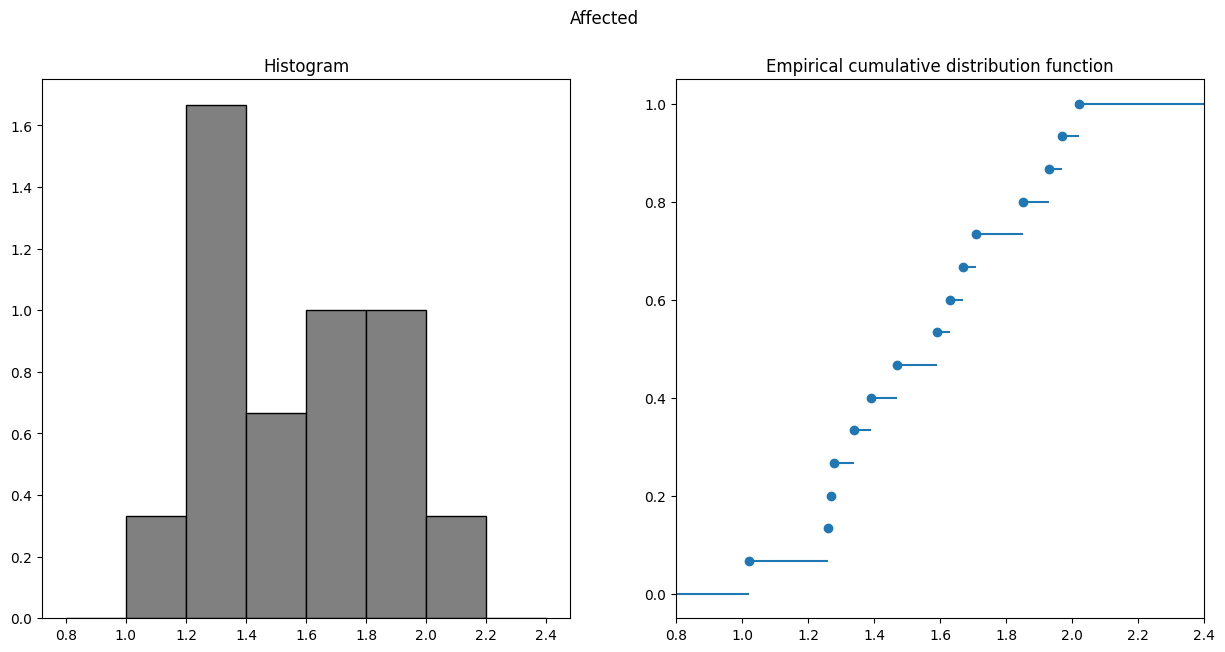

In [28]:
fig, axes = plot_hist_ecdf(aff)
fig.suptitle('Affected')
fig.savefig('img/affected_hist_ecdf.png', format='png')

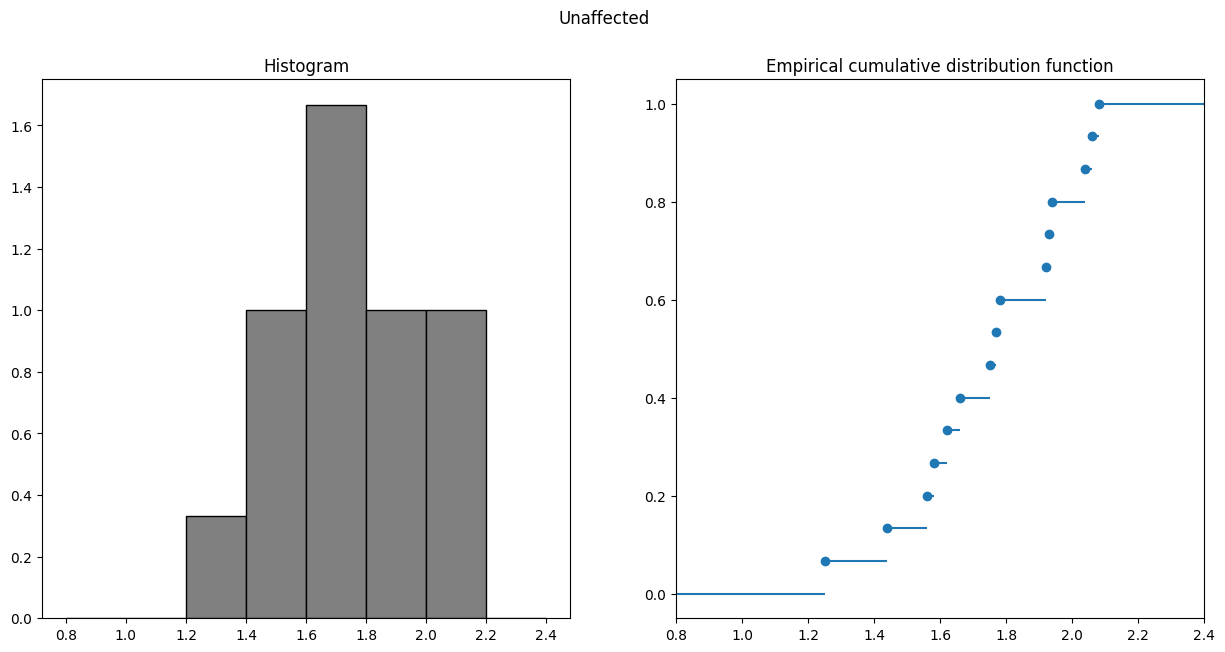

In [10]:
fig, axes = plot_hist_ecdf(una)
fig.suptitle('Unaffected')
fig.savefig('img/unaffected_hist_ecdf.png', format='png')

## Moments method estimating distributions' parameters

In [11]:
def moments_method(X):
    m1 = X.mean()
    m2 = (X ** 2).mean()
    mu_hat= m1
    sigma2_hat= m2 - m1 ** 2
    lambda_hat = 1 / m1
    a_hat = m1 - np.sqrt(3 * (m2 - m1**2))
    b_hat = m1 + np.sqrt(3 * (m2 - m1**2))
    print(f"Normal: {mu_hat=}, {sigma2_hat=}")
    print(f"Exp: {lambda_hat=}")
    print(f"Uniform: {a_hat=}, {b_hat=}")

    def normal(x):
        return np.exp(- (x - mu_hat) ** 2 / (2 * sigma2_hat)) / np.sqrt(2 * np.pi * sigma2_hat)

    def exp(x): # x >= 0
        return lambda_hat * np.exp(-lambda_hat * x)
    
    fig, ax = plt.subplots(figsize=(8,8))
    x = np.arange(0, 3, 0.01)
    ax.hist(
        X, density=True, bins=np.arange(0.8, 2.5, 0.2),
        color='grey', edgecolor='black', alpha=0.5
    )
    ax.plot(
        x, normal(x), lw=3,
        label=(r'$\mathcal{N}(' + f' {mu_hat:.2f} , {sigma2_hat:.2f} ' + ')$')
    )
    ax.plot(
        x, exp(x), lw=3,
        label=f'$Exp({lambda_hat:.2f})$'
    )
    ax.hlines(
        [0, 1 / (b_hat - a_hat), 0], 
        [0, a_hat, b_hat], [a_hat, b_hat, 3], 
        color='purple', lw=3,
        label=(f'$U( {a_hat:.2f} , {b_hat:.2f} )$')
    )
    ax.scatter(X, [0 for _ in X], color='black')
    ax.set_xlim(0.7,2.5)
    fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))
    return fig, dict(
        mu_hat=mu_hat, sigma2_hat=sigma2_hat, a_hat=a_hat, b_hat=b_hat, lambda_hat=lambda_hat
    )

Normal: mu_hat=1.7586666504542028, sigma2_hat=0.05485154612180976
Exp: lambda_hat=0.568612590533706
Uniform: a_hat=1.3530133029203395, b_hat=2.1643199979880663


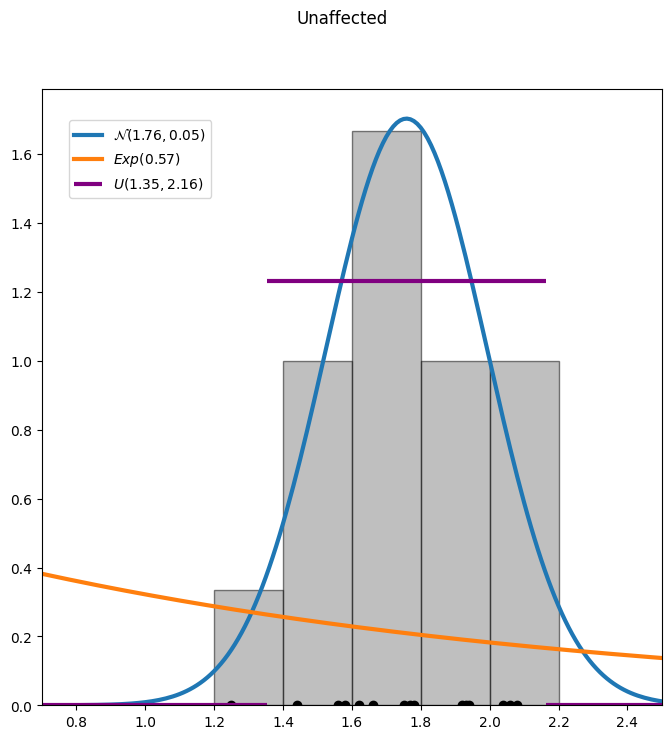

In [12]:
fig, params_una = moments_method(una)
fig.suptitle('Unaffected')
fig.savefig('img/unaffected_distributions.png', format='png')

Normal distribution looks the best, it hits peak close to histograms peak and all data look adequate. Exponential distribution is heavily weighted towards lower values and has a long tail. Uniform distribution could not generate datapoints from bin (1\.2, 1.4), so we will refuse that one too.

Normal: mu_hat=1.5599999984105428, sigma2_hat=0.0847066681798303
Exp: lambda_hat=0.6410256416787711
Uniform: a_hat=1.0558968298631801, b_hat=2.0641031669579055


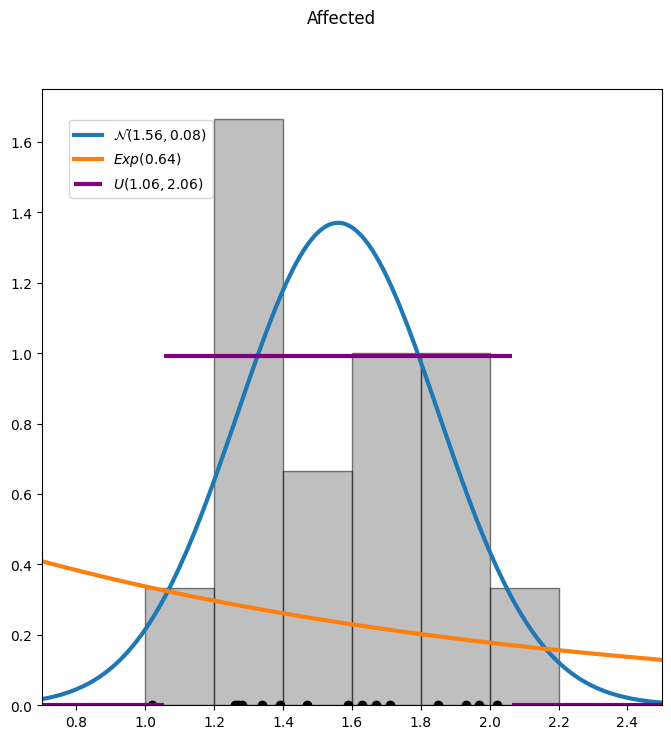

In [13]:
fig, params_aff = moments_method(aff)
fig.suptitle('Affected')
fig.savefig('img/affected_distributions.png', format='png')

It is a close call between normal and uniform distributions. Exponential one performs badly for the very same reasons as before. We will refuse uniform distribution for the very same reasons as before too, though it could be discussed.

## Generating 100 new samples & comparing

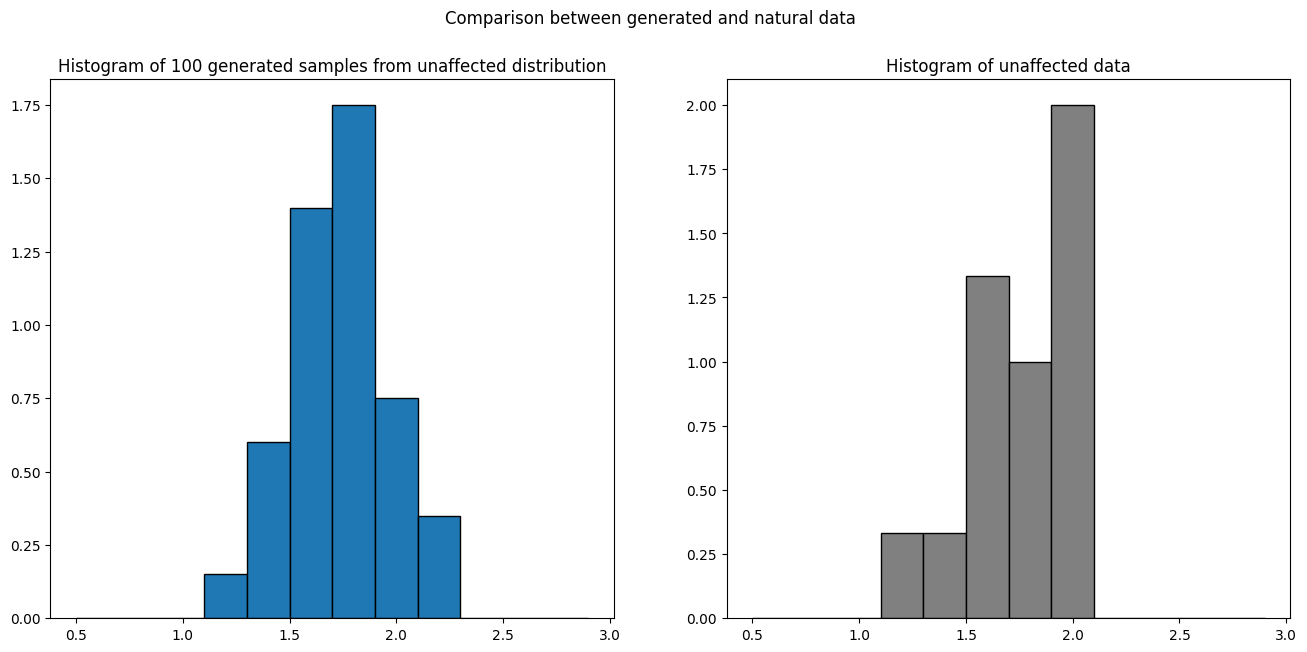

In [14]:
una_samples = stats.norm.rvs(
    loc=params_una['mu_hat'], scale=np.sqrt(params_una['sigma2_hat']),
    size=100, random_state=RND_SEED
)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 7))

ax1.hist(
    una_samples, 
    density=True, 
    bins=np.arange(0.5, params_una['mu_hat'] * 2 - 0.5, 0.2),
    edgecolor='black'
)
ax2.hist(
        una, density=True, 
        bins=np.arange(0.5, params_una['mu_hat'] * 2 - 0.5, 0.2),
        color='grey', edgecolor='black'
)
ax1.set_title('Histogram of 100 generated samples from unaffected distribution')
ax2.set_title('Histogram of unaffected data')
fig.suptitle("Comparison between generated and natural data")
fig.savefig('img/comparing_generated_unaffected.png', format='png')

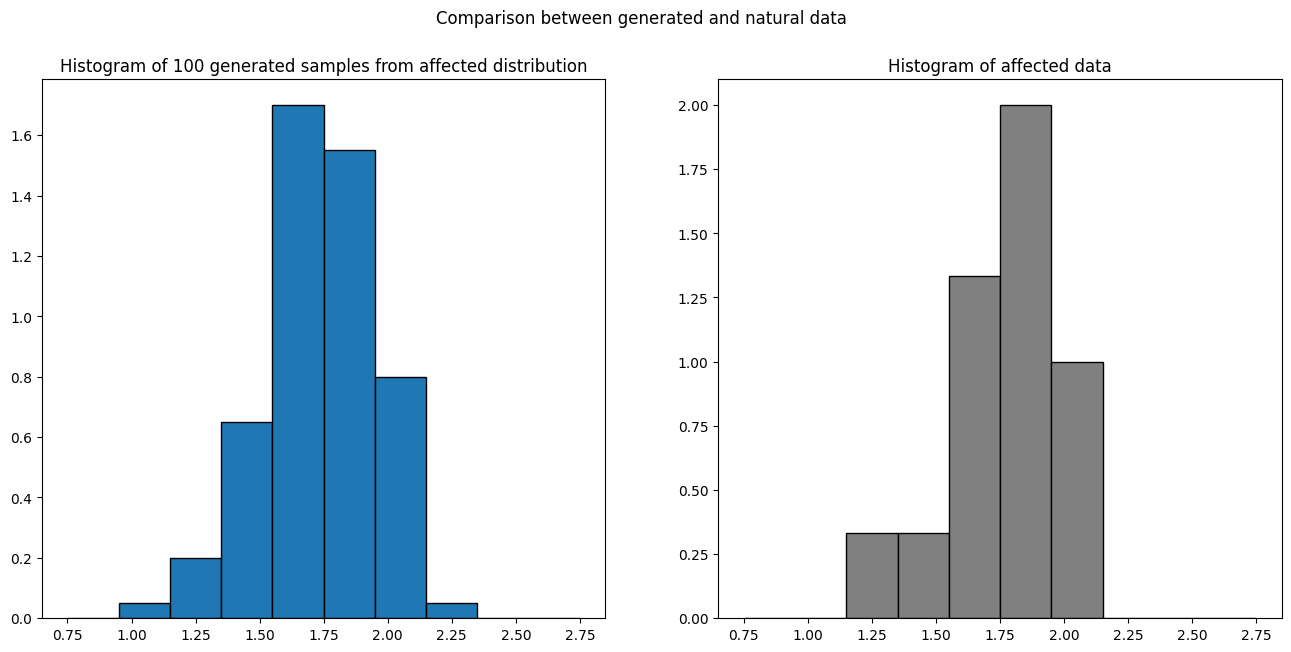

In [15]:
aff_samples = stats.norm.rvs(
    loc=params_aff['mu_hat'], scale=np.sqrt(params_aff['sigma2_hat']),
    size=100, random_state=RND_SEED
)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 7))

ax1.hist(
    una_samples, 
    density=True, 
    bins=np.arange(0.75, params_aff['mu_hat'] * 2 - 0.25, 0.2),
    edgecolor='black'
)
ax2.hist(
        una, density=True, 
        bins=np.arange(0.75, params_aff['mu_hat'] * 2 - 0.25, 0.2),
        color='grey', edgecolor='black'
)
ax1.set_title('Histogram of 100 generated samples from affected distribution')
ax2.set_title('Histogram of affected data')
fig.suptitle("Comparison between generated and natural data")
fig.savefig('img/comparing_generated_affected.png', format='png')

## Confidential interval for mean

In [16]:
def compute_interval(X, alpha=0.05, n=n):
    m = X.mean()
    s = ((X - X.mean()) ** 2).sum() / (n - 1)
    t_alpha_2 = stats.t.isf(alpha/2, df=n-1)
    L = m - t_alpha_2 * s / np.sqrt(n)
    R = m + t_alpha_2 * s / np.sqrt(n)
    return L, R

print(f"Confidential interval for unaffected is: {compute_interval(una)}")
print(f"Confidential interval for affected is: {compute_interval(aff)}")

Confidential interval for unaffected is: (1.726121178559338, 1.7912121223490676)
Confidential interval for affected is: (1.509740367033295, 1.6102596297877907)


## Testing if $K = 14$ is mean for 5% 

$H_0: \mathbb{E}X_{\text{aff}} = K$

$H_A: \mathbb{E}X_{\text{aff}} \neq K$

We reject null hypothesis for 5% because $K = 14 \not\in (1.50, 1.61) $

## Testing if means of both distributions equal

We will be cocluding left hypothesis test, because we would like to derive a method to differ people affected and unaffected by schizofrenia. We obtained $\widehat{\mathbb{E}X_{\text{unaff}}} = 1.75$ and $\widehat{\mathbb{E}X_{\text{aff}}} = 1.56$, so it will natural to assume, that those who are affected have smaller hypocampus.

$H_0: \mathbb{E}X_{\text{aff}} = \mathbb{E}X_{\text{unaff}}$


$H_A: \mathbb{E}X_{\text{aff}} < \mathbb{E}X_{\text{unaff}}$

Equivalently


$H_0: \mathbb{E} \left(X_{\text{aff}} -X_{\text{unaff}}\right) = 0$


$H_A: \mathbb{E} \left(X_{\text{aff}} - X_{\text{unaff}}\right) < 0$

In [17]:
X = aff - una
m = X.mean()
s = (X ** 2).sum() / (n - 1)
alpha = 0.05

R = m + stats.t.isf(alpha, df=n-1) * s / np.sqrt(n)
print(f"Left CI is: (-inf, {R})")

Left CI is: (-inf, -0.15361210674055975)


We reject null hypothesis because $0 \not\in (-\infty, -0.15)$